# Deep learning labs, part 2

## Imports

In [1]:
from glob import glob
import json
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything

from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop, ToTensor)

from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse, load_sequential)

seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Seed set to 0


In [4]:
max_num_workers = rec_num_workers()
max_num_workers

8

In [20]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],[training_legend, valid_legend]):
        results.plot(
            x='epoch',
            y=column,
            label=label,
            marker='o',
            color=color,
            ax=ax, alpha=.8,
        )
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

## IMDB document classification

### Loading the data

In [2]:
(imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
# include only non-zero samples
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

Retrieving "IMDB_S_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_S_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_test.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_train.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

Display words from the `lookup` dictionary.

In [3]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

### Data module

In [5]:
(imdb_train, imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(
    imdb_train,
    imdb_test,
    validation=2000,
    num_workers=min(6, max_num_workers),
    batch_size=512,
)

Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


### NN model

In [6]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        _maps = [
            self.dense1,
            self.activation,
            self.dense2,
            self.activation,
            self.output,
        ]
        for _map in _maps:
            val = _map(val)
        return torch.flatten(val)

#### Model summary

In [7]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(
    imdb_model,
    input_size=imdb_test.tensors[0].size(),
    col_names=[
        'input_size',
        'output_size',
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (G): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

### Model setup

In [8]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
    imdb_model,
    optimizer=imdb_optimizer,
)

### Training

In [ ]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    logger=imdb_logger,
    callbacks=[ErrorTracker()])
imdb_trainer.fit(
    imdb_module,
    datamodule=imdb_dm,
)

### Test results

In [10]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

Testing: |                                                                                                                                                                            | 0/? [00:00<?, ?it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 97.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8501200079917908
        test_loss            1.086784839630127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.086784839630127, 'test_accuracy': 0.8501200079917908}]

### Comparison to Lasso

In [11]:
(
    (X_train, Y_train),
    (X_valid, Y_valid),
    (X_test, Y_test),
) = load_sparse(
    validation=2000,
    random_state=0,
    root='data/IMDB',
)

Retrieving "IMDB_X_test.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


Lasso regularization param.

In [12]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1), np.log(1e-4), 50))

In [14]:
logit = LogisticRegression(
    penalty='l1', 
    C=1/lam_max,
    solver='liblinear',
    warm_start=True,
    fit_intercept=True,
)

In [15]:
coefs, intercepts = [], []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [16]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

Comparison plot.

In [18]:
%%capture
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                    ['Training', 'Validation', 'Test'],
                    ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 '.--',
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)

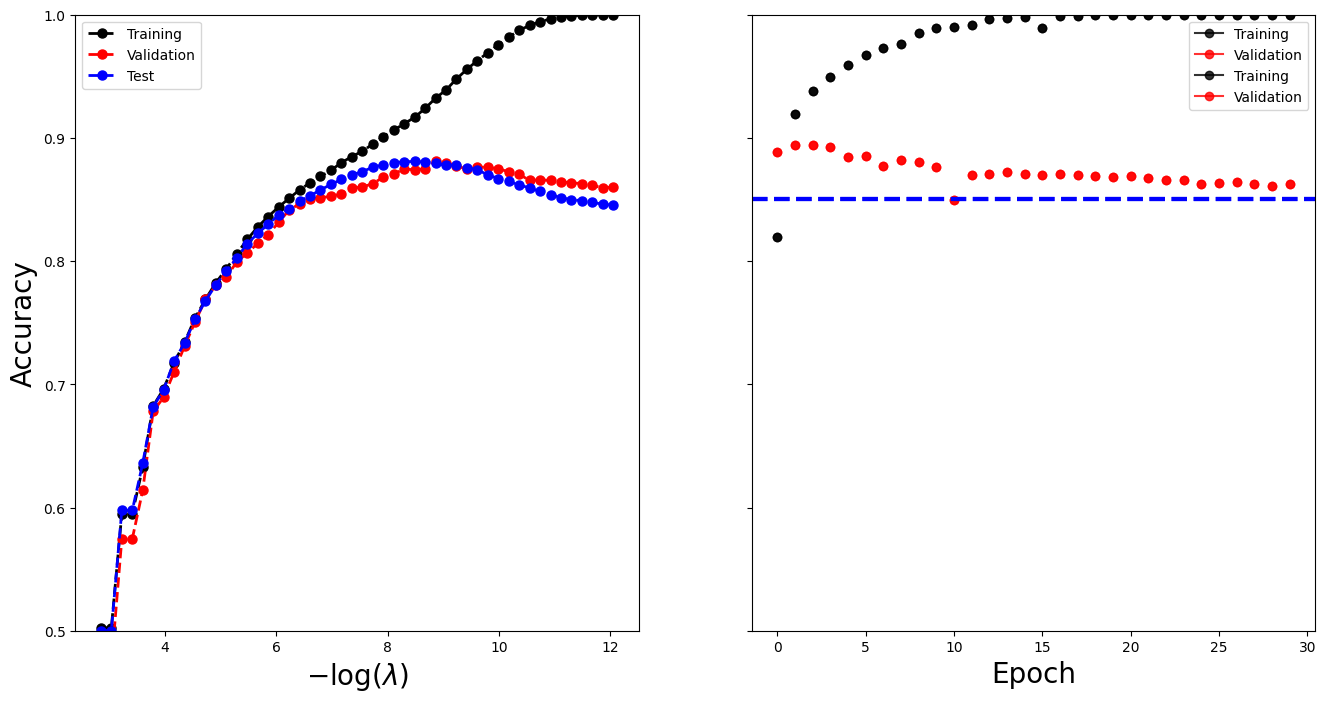

In [22]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col='accuracy',
             ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig

### Cleanup

In [23]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)